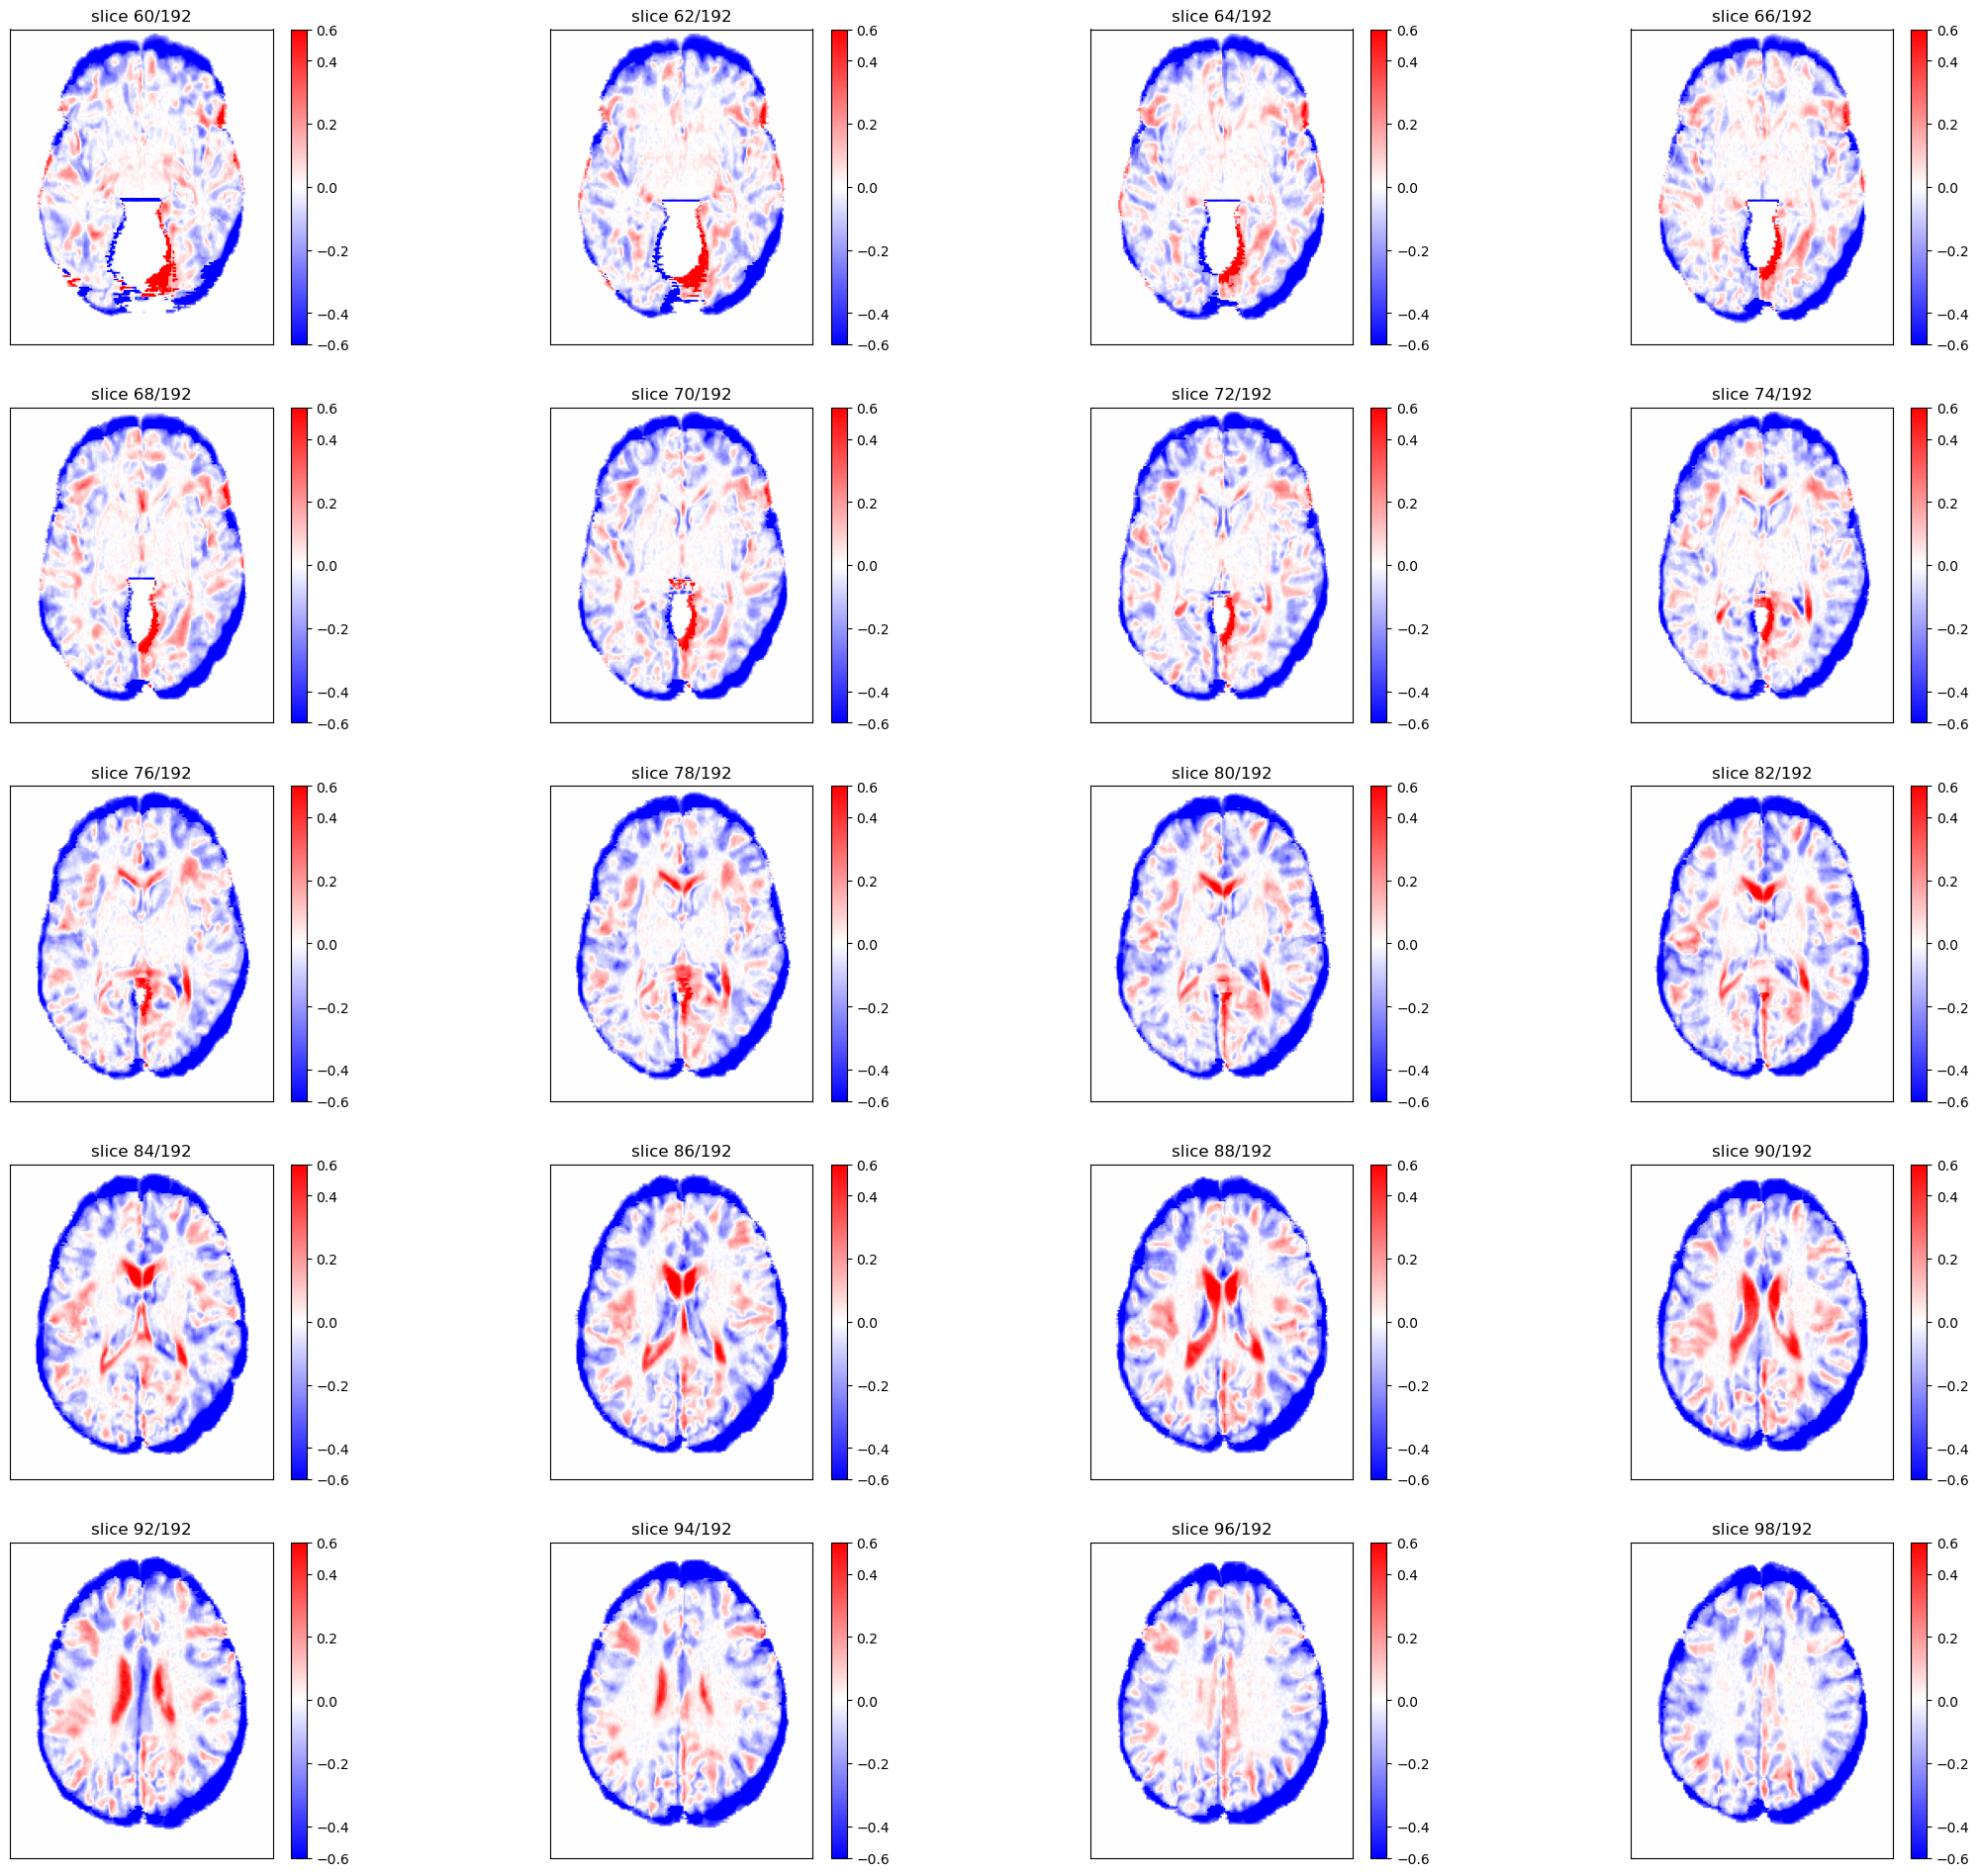

In [45]:
import matplotlib
%matplotlib inline
import matplotlib as mpl
from matplotlib import pylab as plt
import matplotlib.colors as mcolors
# matplotlib.use('TkAgg')  # If use this line, the show of image will generate a new window out of jupyter.

import numpy as np
import pylab

import nibabel as nib
from nibabel import nifti1
from nibabel.viewers import OrthoSlicer3D

pylab.rcParams['figure.figsize'] = (27.0, 24.0)

class MidpointNormalize(mpl.colors.Normalize):
    ## class from the mpl docs:
    # https://matplotlib.org/users/colormapnorms.html

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        super().__init__(vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

example_filename = './fixed.nii.gz'  # fixed image
img1 = nib.load(example_filename)
# print(img1.header['db_name'])  # 输出头信息

example2_filename = './deformed_S2.nii.gz'  # warped image
# example2_filename = './S11.nii.gz'  # moving image
img2 = nib.load(example2_filename)
# print(img2.header['db_name'])  # 输出头信息

width, height, queue = img1.dataobj.shape
# OrthoSlicer3D(img.dataobj).show()

num = 1
for i in range(60, 100, 2):
#     img_arr1 = img1.dataobj[:, :, i]
#     img_arr2 = img2.dataobj[:, :, i]
    img_arr1 = img1.dataobj[:, :, i]
    img_arr2 = img2.dataobj[:, :, i]
    img_arr_diff = img_arr1 - img_arr2
    img_arr_diff = np.rot90(img_arr_diff, 1)
    plt.subplot(5, 4, num)
    plt.title('slice ' + str(i) + '/' + str(height))
    plt.imshow(img_arr_diff, cmap='bwr', norm=MidpointNormalize(midpoint=0))
    plt.clim(-0.5,0.5)
    plt.xticks([])
    plt.yticks([])
    
    plt.colorbar(fraction=0.046, pad=0.04)
    num += 1
# plt.show()
# plt.figure(figsize=(150,100))

In [30]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as nnf
import nibabel as nib
import matplotlib.pyplot as plt

class SpatialTransformer(nn.Module):
    """
    N-D Spatial Transformer
    """

    def __init__(self, size, mode="bilinear"):
        super().__init__()

        self.mode = mode

        # create sampling grid
        vectors = [torch.arange(0, s) for s in size]
        grids = torch.meshgrid(vectors)
        grid = torch.stack(grids)
        grid = torch.unsqueeze(grid, 0)
        grid = grid.type(torch.FloatTensor)

        # registering the grid as a buffer cleanly moves it to the GPU, but it also
        # adds it to the state dict. this is annoying since everything in the state dict
        # is included when saving weights to disk, so the model files are way bigger
        # than they need to be. so far, there does not appear to be an elegant solution.
        # see: https://discuss.pytorch.org/t/how-to-register-buffer-without-polluting-state-dict
        self.register_buffer("grid", grid)

    def forward(self, src, flow):
        # new locations
        new_locs = self.grid + flow
        shape = flow.shape[2:]

        # need to normalize grid values to [-1, 1] for resampler
        for i in range(len(shape)):
            new_locs[:, i, ...] = 2 * \
                (new_locs[:, i, ...] / (shape[i] - 1) - 0.5)

        # move channels dim to last position
        # also not sure why, but the channels need to be reversed
        if len(shape) == 2:
            new_locs = new_locs.permute(0, 2, 3, 1)
            new_locs = new_locs[..., [1, 0]]
        elif len(shape) == 3:
            new_locs = new_locs.permute(0, 2, 3, 4, 1)
            new_locs = new_locs[..., [2, 1, 0]]

        return nnf.grid_sample(src, new_locs, align_corners=True, mode=self.mode)
    
def mk_grid_img(grid_step=8, line_thickness=1, grid_sz=(160, 192, 224)):
    grid_img = np.zeros(grid_sz)
    
    for i in range(0, grid_img.shape[2], grid_step):
        grid_img[:, :, i+line_thickness-1] = 1
    for j in range(0, grid_img.shape[1], grid_step):
        grid_img[:, j+line_thickness-1, :] = 1
    for k in range(0, grid_img.shape[0], grid_step):
        grid_img[k+line_thickness-1, :, :] = 1

    grid_img = grid_img[None, None, ...]
    grid_img = torch.from_numpy(grid_img).float()
    return grid_img

def comput_fig(img):
    img = img.detach().cpu().numpy()[0, 0, :, :, 48:64]
    fig = plt.figure(figsize=(12, 12), dpi=180)
    for i in range(img.shape[-1]):
        plt.subplot(4, 4, i + 1)
        plt.axis('off')
        plt.imshow(img[:, :, i], cmap='gray')
    fig.subplots_adjust(wspace=0, hspace=0)
    return fig

(160, 192, 160, 1, 3)
torch.Size([1, 1, 160, 192, 160])


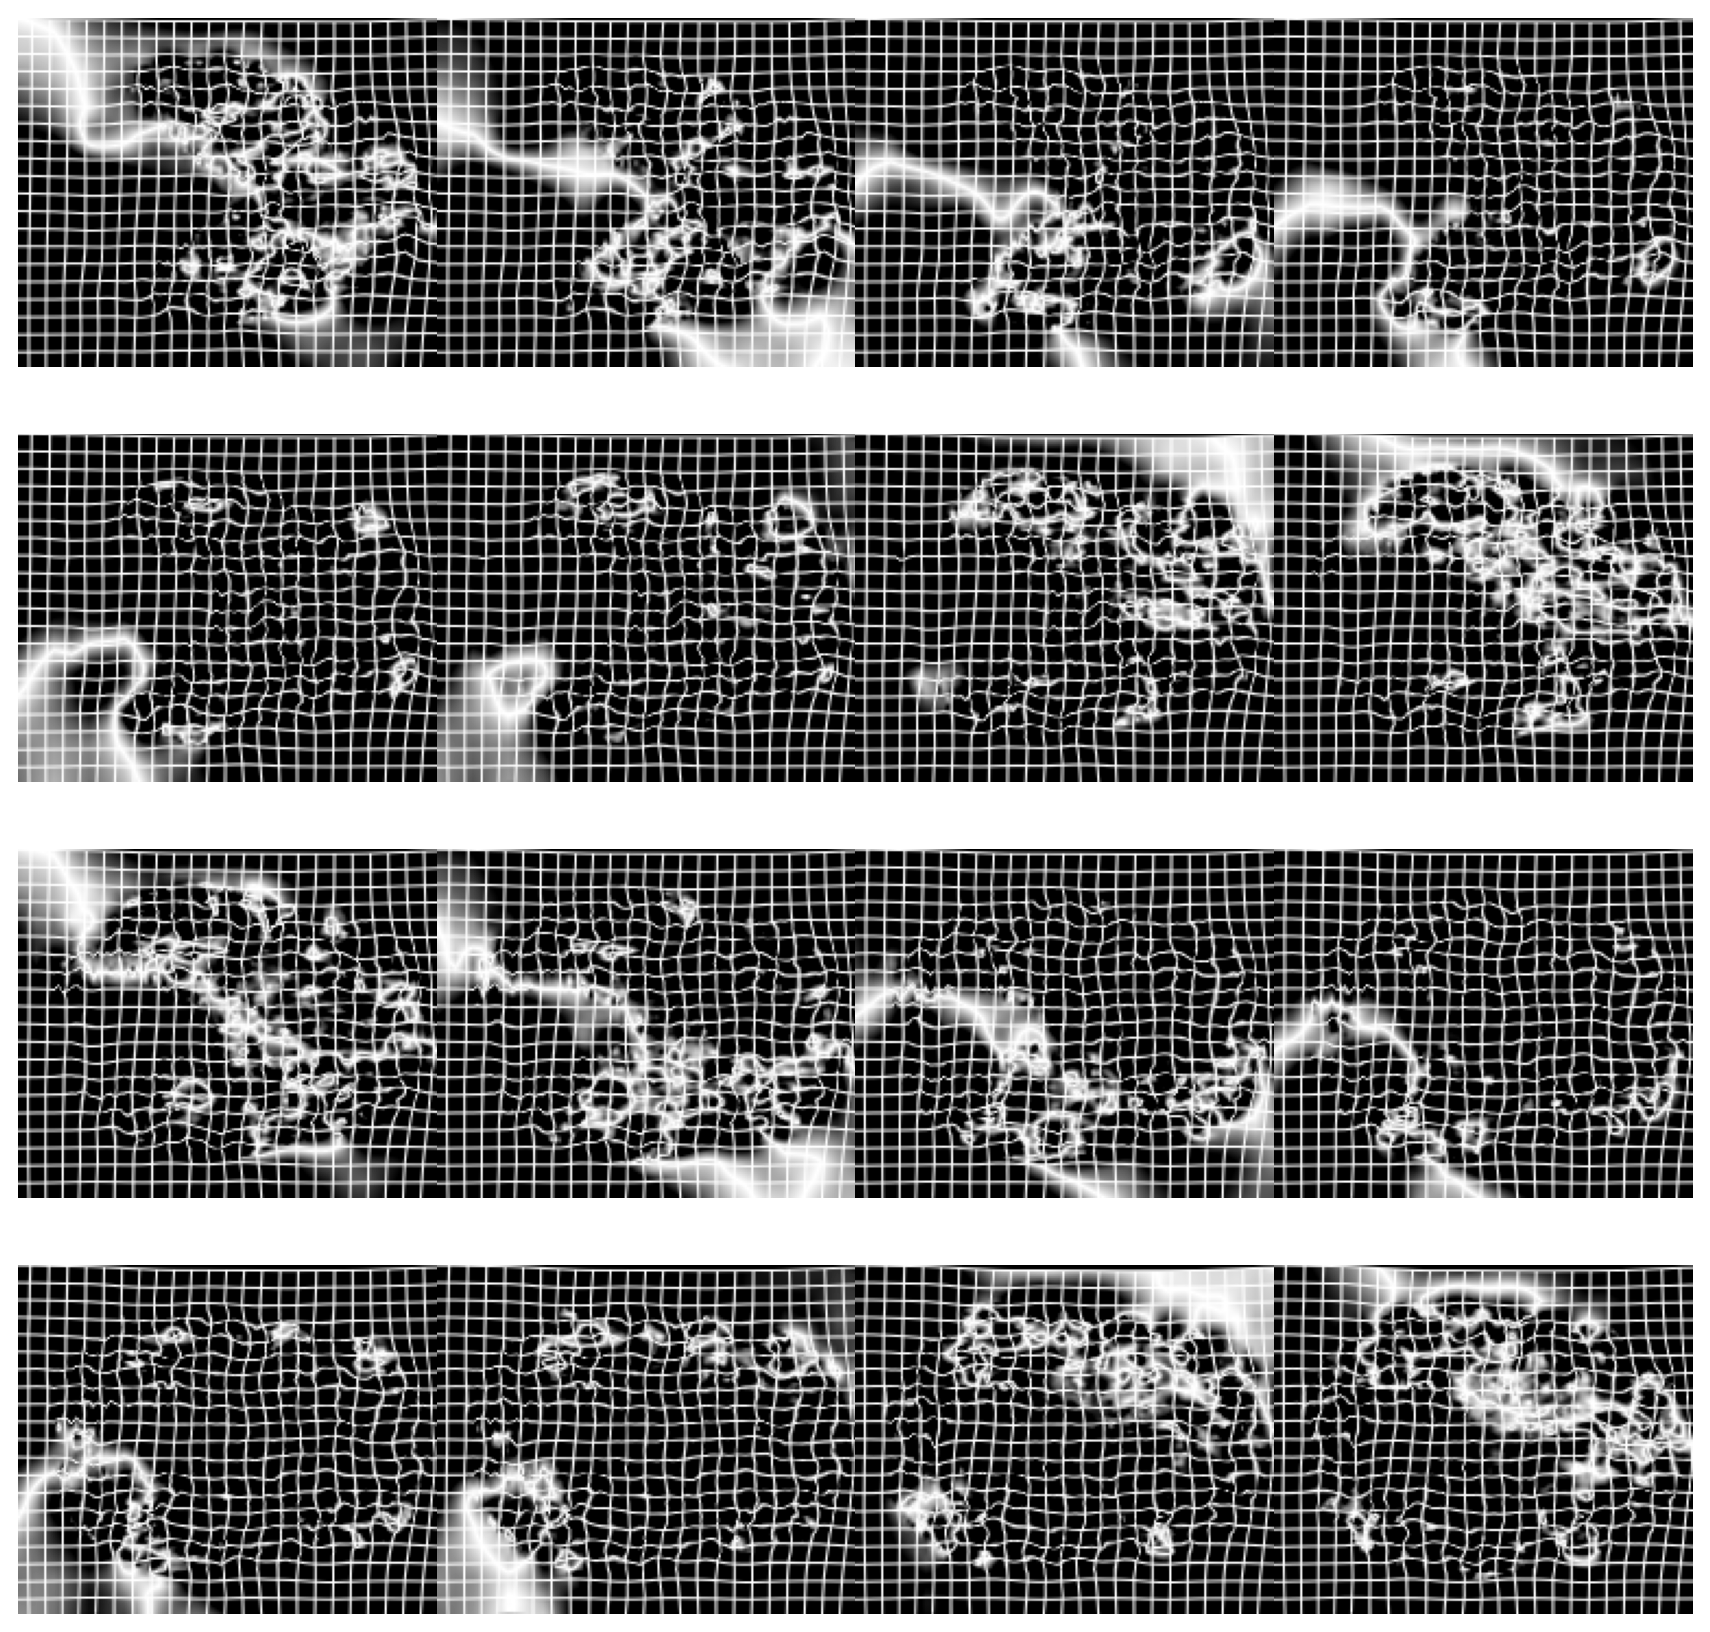

In [31]:
img_size = (160, 192, 160)
stn = SpatialTransformer(size=img_size, mode='bilinear')
grid_img = mk_grid_img(grid_sz=img_size)

flow_filename = './S02_flow.nii.gz'  # flow image
flow = nib.load(flow_filename)
flow = flow.get_fdata()
print(flow.shape)
flow = torch.tensor(flow).float()
flow = flow.permute(3, 4, 0, 1, 2)
warped_img = stn(grid_img, flow)
print(warped_img.shape)
fig = comput_fig(warped_img)
plt.show()



torch.Size([160, 192, 160])


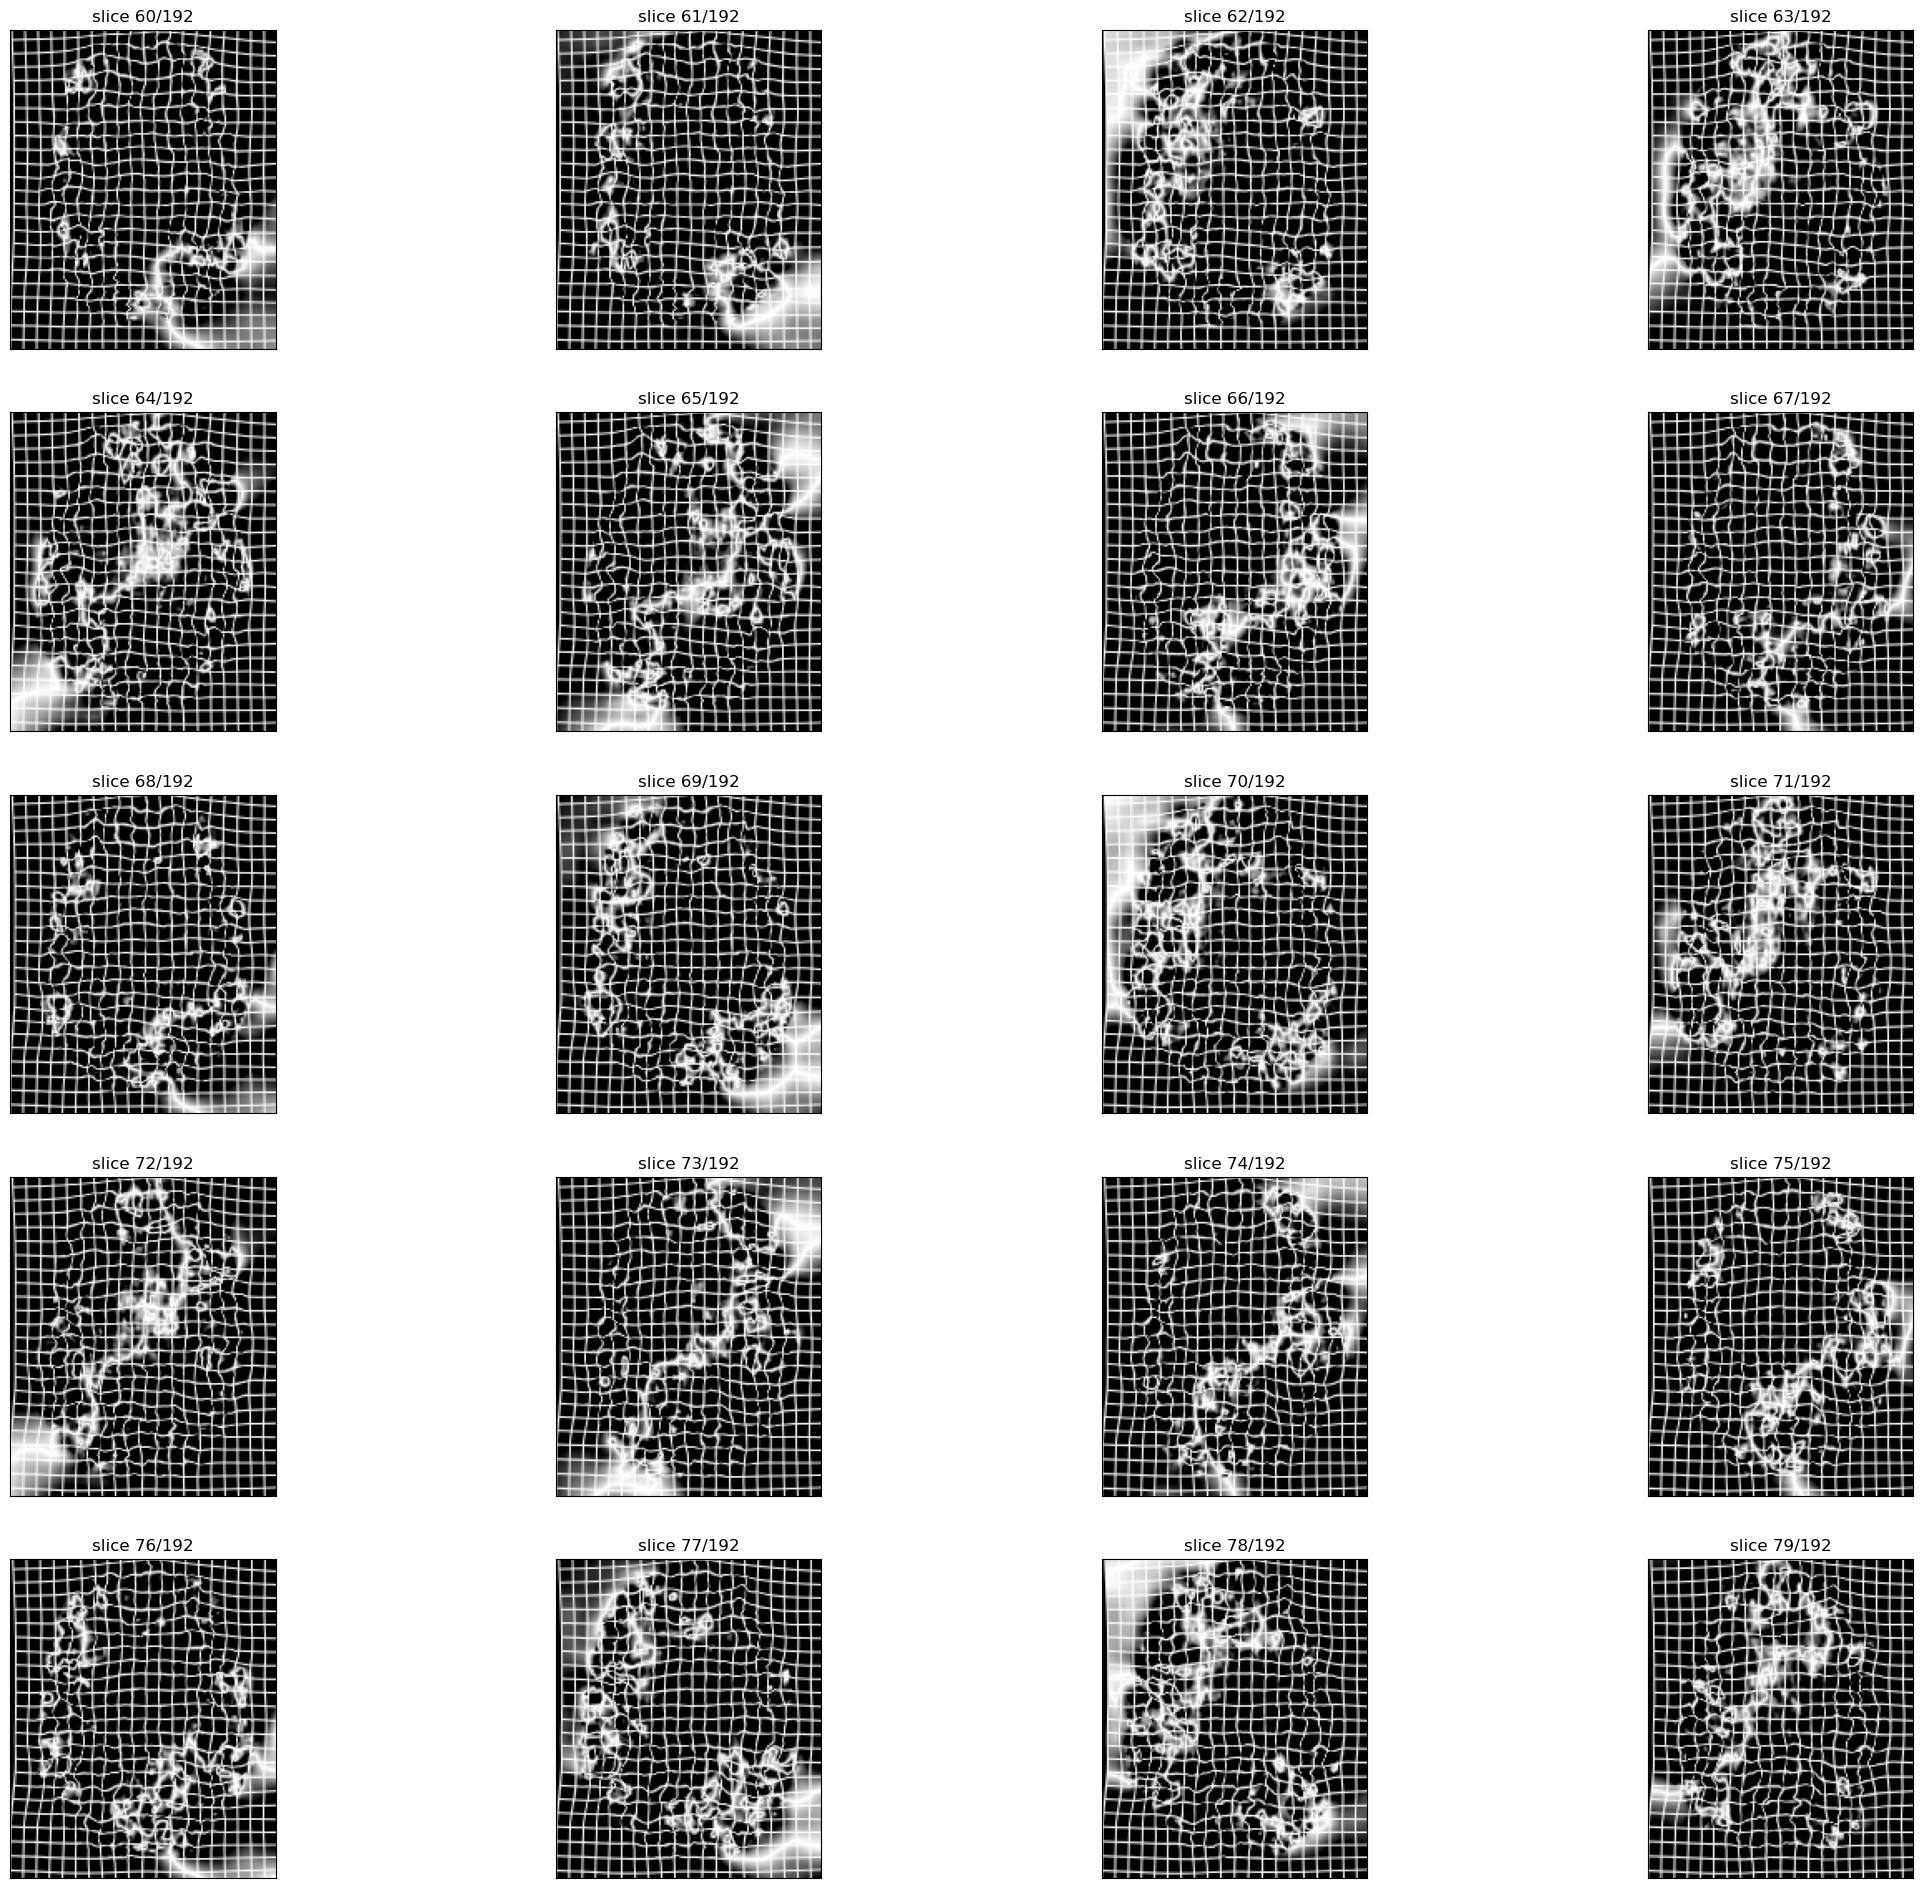

In [42]:

warped_img_array = warped_img[0, 0, ...]
print(warped_img_array.shape)

num = 1
width, height, queue = warped_img_array.shape

for i in range(60, 80, 1):

    img_arr = warped_img_array[:, :, i]
    img_arr = np.rot90(img_arr, 1)
    plt.subplot(5, 4, num)
    plt.title('slice ' + str(i) + '/' + str(height))
    plt.imshow(img_arr, cmap='gray')

    plt.xticks([])
    plt.yticks([])

    num += 1



In [36]:
from matplotlib import colormaps
list(colormaps)

['magma',
 'inferno',
 'plasma',
 'viridis',
 'cividis',
 'twilight',
 'twilight_shifted',
 'turbo',
 'Blues',
 'BrBG',
 'BuGn',
 'BuPu',
 'CMRmap',
 'GnBu',
 'Greens',
 'Greys',
 'OrRd',
 'Oranges',
 'PRGn',
 'PiYG',
 'PuBu',
 'PuBuGn',
 'PuOr',
 'PuRd',
 'Purples',
 'RdBu',
 'RdGy',
 'RdPu',
 'RdYlBu',
 'RdYlGn',
 'Reds',
 'Spectral',
 'Wistia',
 'YlGn',
 'YlGnBu',
 'YlOrBr',
 'YlOrRd',
 'afmhot',
 'autumn',
 'binary',
 'bone',
 'brg',
 'bwr',
 'cool',
 'coolwarm',
 'copper',
 'cubehelix',
 'flag',
 'gist_earth',
 'gist_gray',
 'gist_heat',
 'gist_ncar',
 'gist_rainbow',
 'gist_stern',
 'gist_yarg',
 'gnuplot',
 'gnuplot2',
 'gray',
 'hot',
 'hsv',
 'jet',
 'nipy_spectral',
 'ocean',
 'pink',
 'prism',
 'rainbow',
 'seismic',
 'spring',
 'summer',
 'terrain',
 'winter',
 'Accent',
 'Dark2',
 'Paired',
 'Pastel1',
 'Pastel2',
 'Set1',
 'Set2',
 'Set3',
 'tab10',
 'tab20',
 'tab20b',
 'tab20c',
 'magma_r',
 'inferno_r',
 'plasma_r',
 'viridis_r',
 'cividis_r',
 'twilight_r',
 'twilight